In [1]:
import uproot
import awkward as ak
import vector
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = '../data/DoubleMuonLowMass_Run2018A.root'

data = uproot.open(f'{data_path}:Events;1')

In [3]:
data_length = len(data['event'].array())


target_hlt_keys = [
    'HLT_Tau3Mu_Mu5_Mu1_TkMu1_IsoTau10_Charge1',
    'HLT_Tau3Mu_Mu7_Mu1_TkMu1_IsoTau15_Charge1',
    'HLT_Tau3Mu_Mu7_Mu1_TkMu1_Tau15_Charge1',
]

data_hlt_keys = data.keys(filter_name='HLT_Tau3Mu*')

hlt_keys = [hlt_key for hlt_key in target_hlt_keys if hlt_key in data_hlt_keys]

print(f"hlt_keys: {hlt_keys}")

hlt_mask = ak.Array(np.zeros(data_length, dtype=bool))

for hlt_key in hlt_keys:
    hlt_mask = hlt_mask | data[hlt_key].array()


print(f"Before filtering, Event #: {data_length}")
print(f"After filtering, Event #: {np.count_nonzero(hlt_mask)}")

hlt_keys: ['HLT_Tau3Mu_Mu7_Mu1_TkMu1_IsoTau15_Charge1', 'HLT_Tau3Mu_Mu7_Mu1_TkMu1_Tau15_Charge1']
Before filtering, Event #: 2040266
After filtering, Event #: 322902


In [37]:
muon_mediumId = data['Muon_mediumId'].array()[hlt_mask]

muon_p4 = vector.zip({
    'pt': data['Muon_pt'].array()[hlt_mask],
    'eta': data['Muon_eta'].array()[hlt_mask],
    'phi': data['Muon_phi'].array()[hlt_mask],
    'mass': data['Muon_mass'].array()[hlt_mask]
})

muon_mask1 = (muon_p4.pt > 3.5) & (abs(muon_p4.eta) <= 1.2)
muon_mask2 = (muon_p4.pt > 2.0) & (abs(muon_p4.eta) <= 2.4) & (abs(muon_p4.eta) >= 1.2)

selected_muon = (muon_mask1 | muon_mask2) & muon_mediumId
muon_mask = ak.count(selected_muon, axis=1) >= 3

muon_p4 = muon_p4[muon_mask]

print(ak.count(muon_p4, axis=1))
print(muon_p4.show())


[3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, ..., 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3]
[[{rho: 13, phi: 0.76, eta: 0.813, tau: 0.106}, ..., {rho: 3.9, phi: ..., ...}],
 [{rho: 7.61, phi: -1.81, eta: -2.1, tau: 0.106}, {...}, {rho: 3.57, ...}],
 [{rho: 7.49, phi: -0.707, eta: -0.728, tau: 0.106}, ..., {rho: 3.86, ...}],
 [{rho: 19.9, phi: 0.702, eta: 0.836, tau: 0.106}, ..., {rho: 8.61, ...}],
 [{rho: 9.19, phi: -2.04, eta: 1.39, tau: 0.106}, {...}, ..., {rho: 3.25, ...}],
 [{rho: 8, phi: 1.27, eta: 0.633, tau: 0.106}, ..., {rho: 3.89, phi: ..., ...}],
 [{rho: 11.7, phi: 2.32, eta: -1.14, tau: 0.106}, {...}, {rho: 4.63, ...}],
 [{rho: 10.9, phi: 1.68, eta: -1.62, tau: 0.106}, {...}, {rho: 3.28, ...}],
 [{rho: 9.45, phi: -1.47, eta: 1.95, tau: 0.106}, {...}, {rho: 3.52, ...}],
 [{rho: 9.91, phi: -2.03, eta: 1.44, tau: 0.106}, {...}, {rho: 3.68, ...}],
 ...,
 [{rho: 8.42, phi: -0.109, eta: 1.58, tau: 0.106}, ..., {rho: 3.99, ...}],
 [{rho: 8.26, phi: 3.05, eta: -1.69, tau: 0.106}, {...}, {rho: 

In [43]:
print(muon_p4.E)

[[17.6, 7.23, 5.91], [31.6, 6.84, 12.6], ..., [31.2, ...], [39.1, 25.4, 6.74]]


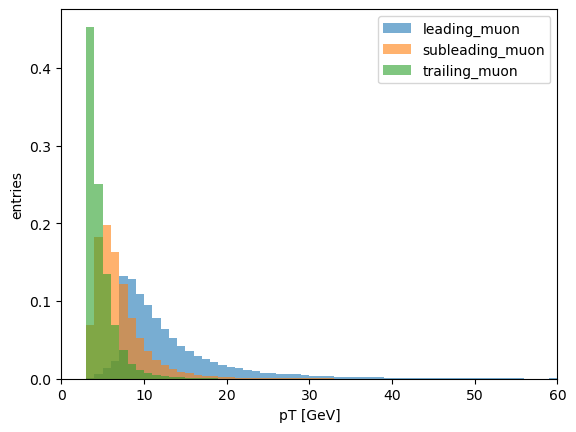

In [42]:
plt.hist(muon_p4.pt[:, 0],              density=True, bins=60, alpha=0.6, range=(0, 60), label="leading_muon")
plt.hist(muon_p4.pt[:, 1],              density=True, bins=60, alpha=0.6, range=(0, 60), label="subleading_muon")
plt.hist(ak.flatten(muon_p4.pt[:, 2:]), density=True, bins=60, alpha=0.6, range=(0, 60), label="trailing_muon")
plt.xlim(0, 60)
plt.xlabel("pT [GeV]")
plt.ylabel("entries")
plt.legend()
plt.show()

In [ ]:
# τ candidates are formed in each event by combining all the possible triplets of muons passing the pre-selection, that is, satisfying the Medium ID requirements and being matched to the objects firing the trigger (for further details on the trigger matching, see Sec.5.4).
# The invariant mass of the τ candidates should be lower than 3 GeV,
# τ candidate charge has to be ±1
# The three muons are fit to a common vertex through a kinematic fit [31], and the vertex is required to be valid.
# The muon tracks are refitted, applying this vertex as a constrain, and the refitted quantities are used in all the following steps of the analysis.
# τ candidates are discarded if any of the three muons can make a “good” vertex with an extra opposite charged muon (not already considered as part of the τ candidate)